In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [3]:
from __future__ import print_function, division

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [4]:
# data_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/mixed_data') 
data_dir = os.path.join('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/giraffOD')

In [5]:
labels = os.listdir(data_dir)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_data = []
labels_data = []
for label in labels:
    for filename in os.listdir(data_dir + '/' + label ):
        files_data.append(data_dir + '/' + label + '/' + filename)
        labels_data.append(label)

In [6]:
labels

['Non_violation', 'Violation']

In [7]:
print("The first five files from the list of train images:", files_data[:5])
print("\nThe first five labels from the list of train labels:", labels_data[:5])

The first five files from the list of train images: ['/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/giraffOD/Non_violation/download.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/giraffOD/Non_violation/giraffe3.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/giraffOD/Non_violation/giraffe6.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/giraffOD/Non_violation/giraffe7.jpg', '/content/gdrive/MyDrive/GTVD-(DS440-Team1)/Data/Data_collection2/giraffOD/Non_violation/giraffe10.jpg']

The first five labels from the list of train labels: ['Non_violation', 'Non_violation', 'Non_violation', 'Non_violation', 'Non_violation']


In [8]:
print(len(labels_data))

38


In [9]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

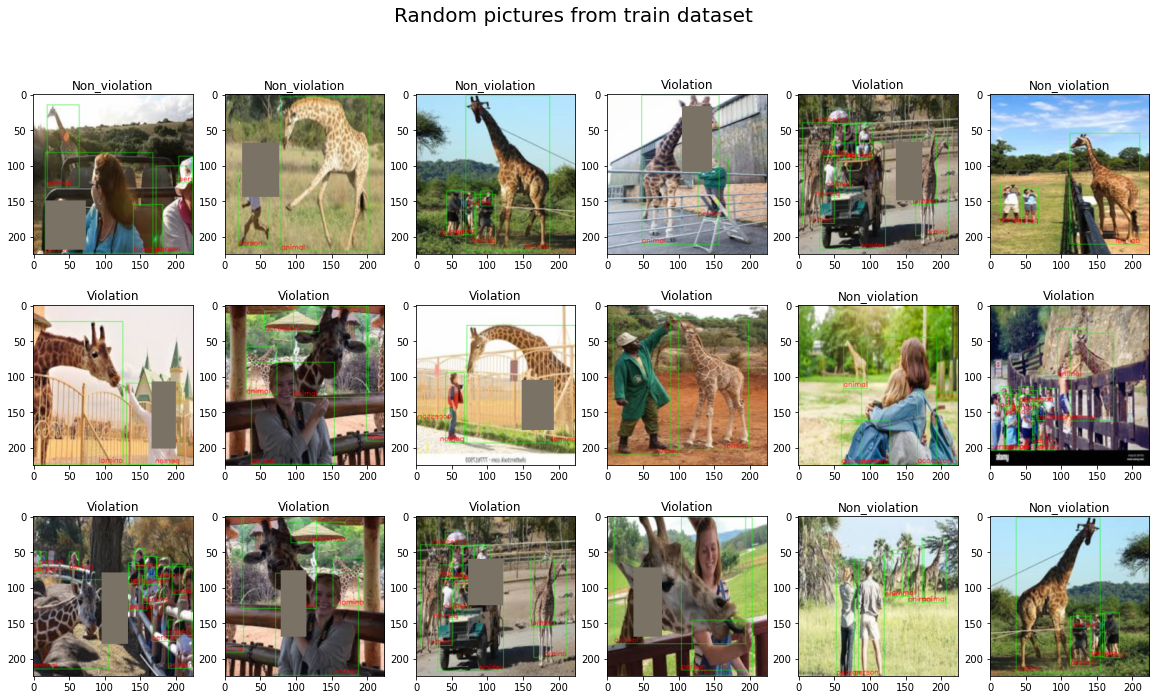

In [10]:

dataset = ImagesDataset(files=files_data,
                              labels=labels_data,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')



fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(dataset))
    img = dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([dataset[n][1]])[0])
    ax.imshow(img)

In [15]:
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [900, 289, 100])
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [18, 15, 5])

In [16]:
print(len(train_dataset),len(val_dataset), len(test_dataset))

18 15 5


In [17]:
labels_test = []
for i in range(len(test_dataset)):
  labels_test.append(encoder_labels.inverse_transform([test_dataset[i][1]])[0])

In [18]:
transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

In [30]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):
    since = time.time()

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.009)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_last_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array
    
    
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
num_epochs = 35

In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model_densenet161 = models.densenet161()
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)
model_densenet161.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/DenseNet161_weights.pth'))

<All keys matched successfully>

In [23]:
model_resnet50 = models.resnet50()
for param in model_resnet50.parameters():
    param.requires_grad = False
model_resnet50.fc = torch.nn.Linear(model_resnet50.fc.in_features, 2)
model_resnet50 = model_resnet50.to(DEVICE)
model_resnet50.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/ResNet50_weights.pth'))

<All keys matched successfully>

In [24]:
model_resnet152 = models.resnet152()
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
model_resnet152 = model_resnet152.to(DEVICE)
model_resnet152.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/ResNet152_weights.pth'))

<All keys matched successfully>

In [25]:
model_vgg16 = models.vgg16()
for param in model_vgg16.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = torch.nn.Linear(in_features=model_vgg16.classifier[6].in_features, out_features=2)
model_vgg16 = model_vgg16.to(DEVICE)
model_vgg16.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/VGG16_weights.pth'))

<All keys matched successfully>

In [26]:
model_vgg19_bn = models.vgg19_bn()
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)
model_vgg19_bn.load_state_dict(torch.load('/content/gdrive/MyDrive/GTVD-(DS440-Team1)/code/VGG19_bn_weights.pth'))

<All keys matched successfully>

In [31]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC, modelD, modelE):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.modelD = modelD
        self.modelE = modelE

        #remove last linear layer
        # self.modelA.fc = nn.Identity()
        # self.modelB.fc = nn.Identity()
        # self.modelC.fc = nn.Identity()
        # self.modelD.fc = nn.Identity()
        # self.modelE.fc = nn.Identity()

        # create new classifier
        self.classifier = nn.Linear(2*5, 2)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x3 = self.modelC(x)
        x3 = x3.view(x3.size(0), -1)
        x4 = self.modelD(x)
        x4 = x4.view(x4.size(0), -1)
        x5 = self.modelE(x)
        x5 = x5.view(x4.size(0), -1)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet50, model_resnet152, model_vgg16, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)
ensemble_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ensembleclassifier4.pth'))

<All keys matched successfully>

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.009]


  3%|▎         | 1/35 [00:13<07:32, 13.31s/it]

	| New lowest val loss for Ensemble: 0.16346420819560686
Epoch: 2 | Learning rate: [0.009]


  6%|▌         | 2/35 [00:26<07:24, 13.47s/it]

	| New lowest val loss for Ensemble: 0.14078443944454194
Epoch: 3 | Learning rate: [0.00297]


  9%|▊         | 3/35 [00:40<07:10, 13.45s/it]

	| New lowest val loss for Ensemble: 0.1320908268292745
Epoch: 4 | Learning rate: [0.00297]


 11%|█▏        | 4/35 [00:47<05:38, 10.92s/it]

Epoch: 5 | Learning rate: [0.0009801]


 14%|█▍        | 5/35 [00:54<04:45,  9.52s/it]

Epoch: 6 | Learning rate: [0.0009801]


 17%|█▋        | 6/35 [01:01<04:11,  8.68s/it]

Epoch: 7 | Learning rate: [0.00032343300000000003]


 20%|██        | 7/35 [01:08<03:48,  8.14s/it]

Epoch: 8 | Learning rate: [0.00032343300000000003]


 23%|██▎       | 8/35 [01:15<03:30,  7.79s/it]

Epoch: 9 | Learning rate: [0.00010673289000000002]


 26%|██▌       | 9/35 [01:22<03:17,  7.61s/it]

Epoch: 10 | Learning rate: [0.00010673289000000002]


 29%|██▊       | 10/35 [01:29<03:05,  7.44s/it]

Epoch: 11 | Learning rate: [3.522185370000001e-05]


 31%|███▏      | 11/35 [01:36<02:55,  7.32s/it]

Epoch: 12 | Learning rate: [3.522185370000001e-05]


 34%|███▍      | 12/35 [01:43<02:46,  7.23s/it]

Epoch: 13 | Learning rate: [1.1623211721000004e-05]


 37%|███▋      | 13/35 [01:50<02:37,  7.18s/it]

Epoch: 14 | Learning rate: [1.1623211721000004e-05]


 40%|████      | 14/35 [01:57<02:29,  7.13s/it]

Epoch: 15 | Learning rate: [3.835659867930001e-06]


 43%|████▎     | 15/35 [02:04<02:22,  7.10s/it]

Epoch: 16 | Learning rate: [3.835659867930001e-06]


 46%|████▌     | 16/35 [02:12<02:17,  7.24s/it]

Epoch: 17 | Learning rate: [1.2657677564169005e-06]


 49%|████▊     | 17/35 [02:19<02:09,  7.17s/it]

Epoch: 18 | Learning rate: [1.2657677564169005e-06]


 51%|█████▏    | 18/35 [02:26<02:01,  7.13s/it]

Epoch: 19 | Learning rate: [4.1770335961757717e-07]


 54%|█████▍    | 19/35 [02:33<01:53,  7.10s/it]

Epoch: 20 | Learning rate: [4.1770335961757717e-07]


 57%|█████▋    | 20/35 [02:40<01:46,  7.07s/it]

Epoch: 21 | Learning rate: [1.3784210867380046e-07]


 60%|██████    | 21/35 [02:47<01:38,  7.07s/it]

Epoch: 22 | Learning rate: [1.3784210867380046e-07]


 63%|██████▎   | 22/35 [02:54<01:31,  7.06s/it]

Epoch: 23 | Learning rate: [4.548789586235415e-08]


 66%|██████▌   | 23/35 [03:01<01:24,  7.06s/it]

Epoch: 24 | Learning rate: [4.548789586235415e-08]


 69%|██████▊   | 24/35 [03:08<01:17,  7.06s/it]

Epoch: 25 | Learning rate: [1.501100563457687e-08]


 71%|███████▏  | 25/35 [03:15<01:10,  7.05s/it]

Epoch: 26 | Learning rate: [1.501100563457687e-08]


 74%|███████▍  | 26/35 [03:22<01:03,  7.05s/it]

Epoch: 27 | Learning rate: [4.9536318594103675e-09]


 77%|███████▋  | 27/35 [03:29<00:56,  7.05s/it]

Epoch: 28 | Learning rate: [4.9536318594103675e-09]


 80%|████████  | 28/35 [03:36<00:49,  7.04s/it]

Epoch: 29 | Learning rate: [1.6346985136054213e-09]


 83%|████████▎ | 29/35 [03:43<00:42,  7.03s/it]

Epoch: 30 | Learning rate: [1.6346985136054213e-09]


 86%|████████▌ | 30/35 [03:51<00:35,  7.04s/it]

Epoch: 31 | Learning rate: [5.39450509489789e-10]


 89%|████████▊ | 31/35 [03:58<00:28,  7.04s/it]

Epoch: 32 | Learning rate: [5.39450509489789e-10]


 91%|█████████▏| 32/35 [04:05<00:21,  7.04s/it]

Epoch: 33 | Learning rate: [1.780186681316304e-10]


 94%|█████████▍| 33/35 [04:12<00:14,  7.03s/it]

Epoch: 34 | Learning rate: [1.780186681316304e-10]


 97%|█████████▋| 34/35 [04:19<00:07,  7.04s/it]

Epoch: 35 | Learning rate: [5.874616048343803e-11]


100%|██████████| 35/35 [04:26<00:00,  7.61s/it]


Training complete in 4m 26s


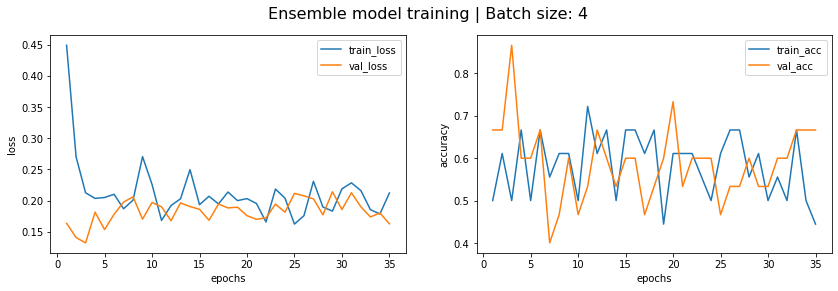


Training results:
	Min val loss 0.1321 was achieved during iteration #3
	Val accuracy during min val loss is 0.8667


In [32]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=35,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=35,
                           model_name="Ensemble model",
                           batch_size=4)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [40]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_preds_decoded = encoder_labels.inverse_transform(all_preds)


100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


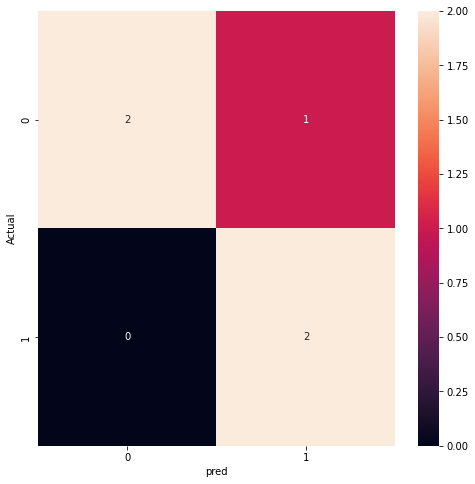

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(labels_test, all_preds_decoded)
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(conf_mat, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('pred')
plt.show()

In [42]:
from sklearn.metrics import classification_report
matrix = classification_report(labels_test, all_preds_decoded,target_names=labels)
print('Classification report : \n',matrix)

Classification report : 
                precision    recall  f1-score   support

Non_violation       1.00      0.67      0.80         3
    Violation       0.67      1.00      0.80         2

     accuracy                           0.80         5
    macro avg       0.83      0.83      0.80         5
 weighted avg       0.87      0.80      0.80         5



In [ ]:
#  !jupyter nbconvert --to html /content/gdrive/MyDrive/Colab\ Notebooks/DS440/reproduce/GiraffTL